# AMPA synapse model

## Model overview

AMPA receptor is an ionotropic receptor of neurotransmitter `Glutamate`. After being bound by Glutamate, it opens the sodium and potassium ion channels and induce postsynaptic current.

AMPA receptor plays important role in long-term potentiation.

This synapse model describes the transmitter-activated ion channel as synaptic conductance $g_{syn}(t)$.

Our implementation is based on BrainPy framework.

In [1]:
import brainpy as bp

We will implement two types of AMPA model. `AMPA 1` is a simple model with one exponential decay, and `AMPA 2` is a HH-like model.

## AMPA 1

Let's first take a look at a simple model with only one exponential decay.

Synaptic conductance $g_{syn}$ is given by:

$$g_{syn} = \bar{g}_{syn} s $$

where $\bar{g}_{syn}$ is the maximum synaptic conductance. 

The gating variable $s$ represents the fraction of open synaptical channel. It's dynamic is given by:

$$\frac{d s}{d t}=-\frac{s}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k})$$

where $\tau_{decay}$ is around 2 to 5 ms.

Here we will implement the dynamics of $g_{syn}$ with a `update()` function.

The synaptic current $I_{syn}$ represents the current that passes through a synaptic channel, which is given by: 

$$I_{syn}= g_{syn} (V-E_{syn})$$

where $V$ is the membrane potential of the post-synaptic neuron (where the receptors and ion channels located in), and the reversal potential $E_{syn}$ for AMPA receptor is $0$.

Post-synaptic input current will be the sum of synaptic current from all channels.

In [2]:
class AMPA1(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau):
        ds = - s / tau
        return ds
    
    def __init__(self, pre, post, conn, delay=0., g_max=0.10, E=0., tau=2.0, **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau = tau
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.backend.shape(self.conn_mat)

        # variables
        self.s = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

        self.int_s = bp.odeint(f=self.derivative, method='exponential_euler')
        super(AMPA1, self).__init__(pre=pre, post=post, **kwargs)


    def update(self, _t):
        self.s = self.int_s(self.s, _t, self.tau)
        self.s += bp.backend.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.g.push(self.g_max * self.s)
        g = self.g.pull()
        self.post.input -= bp.backend.sum(g, axis=0) * (self.post.V - self.E)

### Simulation

Let's define a function to simulate the progress of pre->ampa->post.

We'll apply the current to the synapse (inject action potential to the pre-synaptic neuron by give input to `'pre.sp'`)

In [3]:
import matplotlib.pyplot as plt
import brainmodels

bp.backend.set(backend='numpy', dt=0.05)

def get_neurons():                                 
    pre = brainmodels.neurons.LIF(1, monitors=['spike', 'V'], V_rest=-65., V_reset=-65., V_th=-55.)
    pre.V = -65. * bp.backend.ones(pre.V.shape)
    post = brainmodels.neurons.LIF(1, monitors=['V'], V_rest=-65., V_reset=-65., V_th=-55.)
    post.V = -65. * bp.backend.ones(post.V.shape)
    return pre, post

def get_plots(ts, s, pre_V, post_V, pre_spike):
    # visualization    
    fig, gs = bp.visualize.get_figure(3, 1, 4, 9)

    # pre potential
    fig.add_subplot(gs[0, 0])
    plt.plot(ts, pre_V[:, 0])
    plt.ylabel('pre potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('pre-synaptic potential')
    
    # synapse
    fig.add_subplot(gs[1, 0])
    plt.plot(ts, s[:, 0], label='gating variable')
    plt.plot(ts, pre_spike[:, 0], label='pre spike')
    plt.ylabel('gating variable')
    plt.xlabel('Time (ms)')
    plt.title('synapse dynamics')
    plt.legend()
    
    # PSP
    fig.add_subplot(gs[2, 0])
    plt.plot(ts, post_V[:, 0])
    plt.ylabel('membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('post-synaptic potential (PSP)')

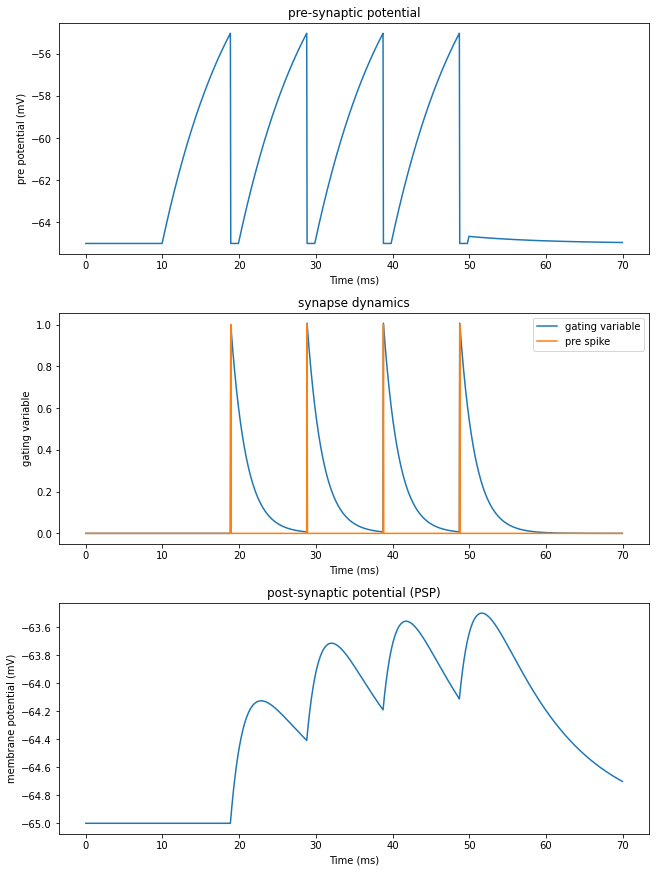

In [4]:
(step_I, duration) = bp.inputs.constant_current([(0, 10), (16.9, 40), (0, 20)])

pre, post = get_neurons()
syn = AMPA1(pre=pre, post=post, conn=bp.connect.All2All(), monitors=['s'])
net = bp.Network(pre, syn, post)
net.run(duration, inputs=(pre, "input", step_I))

get_plots(net.ts, syn.mon.s, pre.mon.V, post.mon.V, pre.mon.spike)

## AMPA 2

We can also make a model which has the flavor of a Hodgkin-Huxley channel.

The synaptic current is given by:

$$ I_{syn}=\bar{g}_{syn} s (V-E_{syn}) $$

where the dynamics of gating variable $s$ is given by:

$$ \frac{ds}{dt} =\alpha[T](1-s)-\beta s $$

where $\alpha$ and $\beta$ are the binding constant and unbinding constant, respectively. $[T]$ indicates the concentration of neurotransmitter. When a presynaptic neuron fire, $[T]=[T]+0.5$, lasting for 0.5 ms.

In [5]:
class AMPA2(bp.TwoEndConn):
    target_backend = 'general'
    
    @staticmethod
    def derivative(s, t, TT, alpha, beta):
        ds = alpha * TT * (1 - s) - beta * s
        return ds

    def __init__(self, pre, post, conn, delay=0., g_max=0.42, E=0.,
                 alpha=0.98, beta=0.18, T=0.5, T_duration=0.5, **kwargs):
        # parameters
        self.delay = delay
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.backend.shape(self.conn_mat)

        # variables
        self.s = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)
        self.t_last_pre_spike = -1e7 * bp.backend.ones(self.size)

        self.int_s = bp.odeint(f=self.derivative, method='exponential_euler')
        super(AMPA2, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        spike = bp.backend.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.t_last_pre_spike = bp.backend.where(spike, _t, self.t_last_pre_spike)
        TT = ((_t - self.t_last_pre_spike) < self.T_duration) * self.T
        self.s = self.int_s(self.s, _t, TT, self.alpha, self.beta)
        self.g.push(self.g_max * self.s)
        self.post.input -= bp.backend.sum(self.g.pull(), 0) * (self.post.V - self.E)

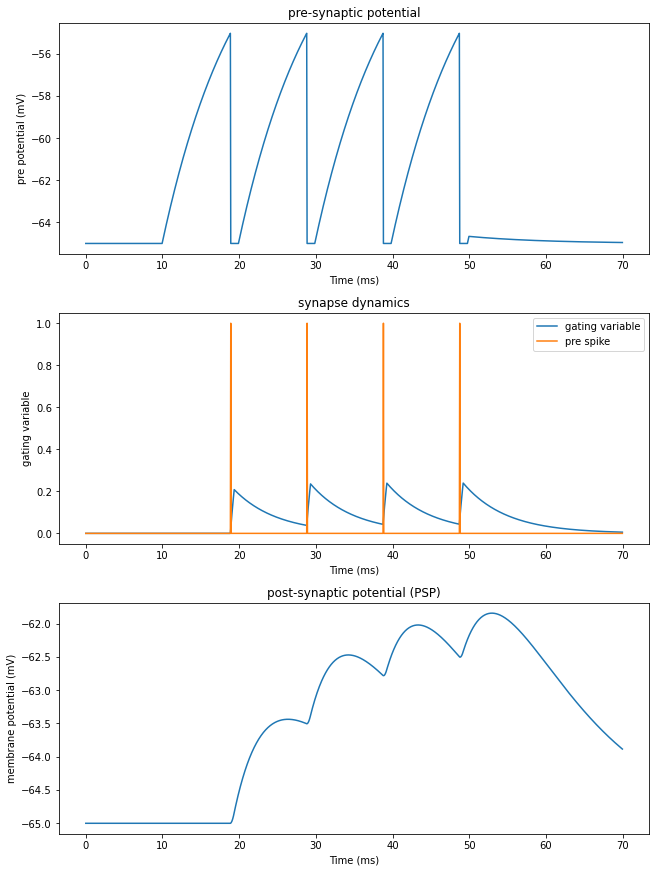

In [6]:
(step_I, duration) = bp.inputs.constant_current([(0, 10), (16.9, 40), (0, 20)])

pre, post = get_neurons()
syn = AMPA2(pre=pre, post=post, conn=bp.connect.All2All(), monitors=['s'])
net = bp.Network(pre, syn, post)
net.run(duration, inputs=(pre, "input", step_I))

get_plots(net.ts, syn.mon.s, pre.mon.V, post.mon.V, pre.mon.spike)

The graphs show similar dynamics of the gating variable between the two models. Since there is only one exponential decay of the AMPA1 model, it decays quickly after pre-synatical spikes. While the dynamic of AMPA2 model is modulated by two constants, it acts smoother.

## Numba backend Implementation

Under numba backend, for loop can be very fast, here we should how to implement with numba ``prange`` (paralle for loop).

Again, we will implement the two kinds of models and compare there results.

$$ I_{syn}=\bar{g}_{syn} s (V-E_{syn}) $$

$$\frac{d s}{d t}=-\frac{s}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k}) $$

In [7]:
from numba import prange

class AMPA1_numba(bp.TwoEndConn):
    target_backend = ['numba', 'numpy', 'numba-parallel', 'numba-cuda']

    @staticmethod
    def derivative(s, t, tau):
        ds = - s / tau
        return ds
    
    def __init__(self, pre, post, conn, delay=0., g_max=0.10, E=0., tau=2.0, **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau = tau
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
        self.size = len(self.pre_ids)

        # variables
        self.s = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

        self.int_s = bp.odeint(f=self.derivative, method='exponential_euler')
        super(AMPA1_numba, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        for i in prange(self.size):
            pre_id = self.pre_ids[i]
            self.s[i] = self.int_s(self.s[i], _t, self.tau)
            self.s[i] += self.pre.spike[pre_id]
            self.g.push(i, self.g_max * self.s[i])
            post_id = self.post_ids[i]
            self.post.input[post_id] -= self.g.pull(i) * (self.post.V[post_id] - self.E)

In [8]:
class AMPA2_numba(bp.TwoEndConn):
    target_backend = ['numba', 'numpy', 'numba-parallel', 'numba-cuda']
    
    @staticmethod
    def derivative(s, t, TT, alpha, beta):
        ds = alpha * TT * (1 - s) - beta * s
        return ds

    def __init__(self, pre, post, conn, delay=0., g_max=0.42, E=0.,
                 alpha=0.98, beta=0.18, T=0.5, T_duration=0.5, **kwargs):
        # parameters
        self.delay = delay
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration

        # connections
        self.conn = conn(pre.size, post.size)
        self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
        self.size = len(self.pre_ids)

        # variables
        self.s = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)
        self.t_last_pre_spike = -1e7 * bp.backend.ones(self.size)

        self.int_s = bp.odeint(f=self.derivative, method='exponential_euler')
        super(AMPA2_numba, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        for i in prange(self.size):
            pre_id = self.pre_ids[i]
            post_id = self.post_ids[i]

            if self.pre.spike[pre_id]:
                self.t_last_pre_spike[pre_id] = _t
            TT = ((_t - self.t_last_pre_spike[pre_id]) < self.T_duration) * self.T
            self.s[i] = self.int_s(self.s[i], _t, TT, self.alpha, self.beta)
            self.g.push(i, self.g_max * self.s[i])
            self.post.input[post_id] -= self.g.pull(i) * (self.post.V[post_id] - self.E)

### Simulation

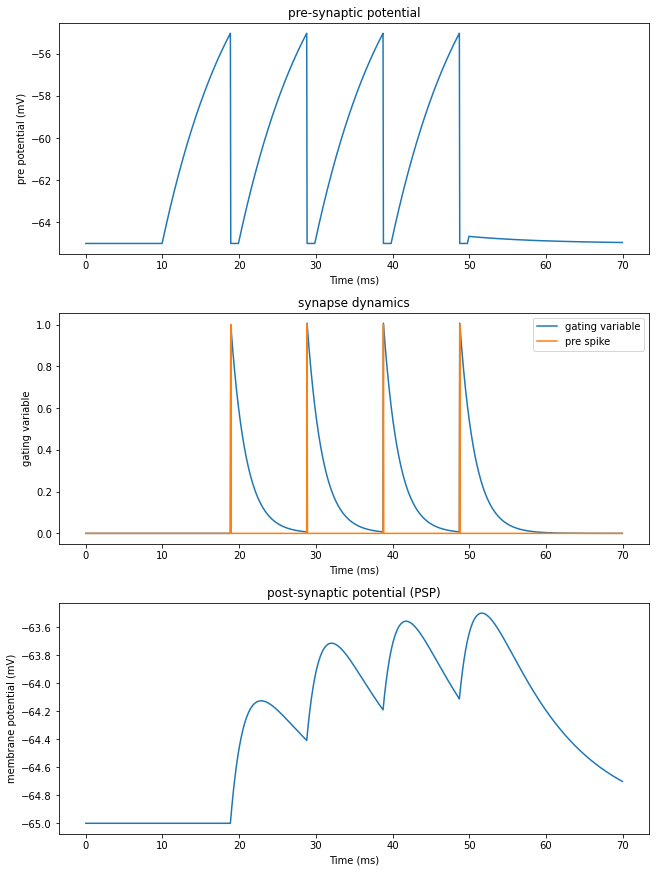

In [9]:
bp.backend.set(backend='numba')

(step_I, duration) = bp.inputs.constant_current([(0, 10), (16.9, 40), (0, 20)])

pre, post = get_neurons()
syn = AMPA1_numba(pre=pre, post=post, conn=bp.connect.All2All(), monitors=['s'])
net = bp.Network(pre, syn, post)
net.run(duration, inputs=(pre, "input", step_I))

get_plots(net.ts, syn.mon.s, pre.mon.V, post.mon.V, pre.mon.spike)

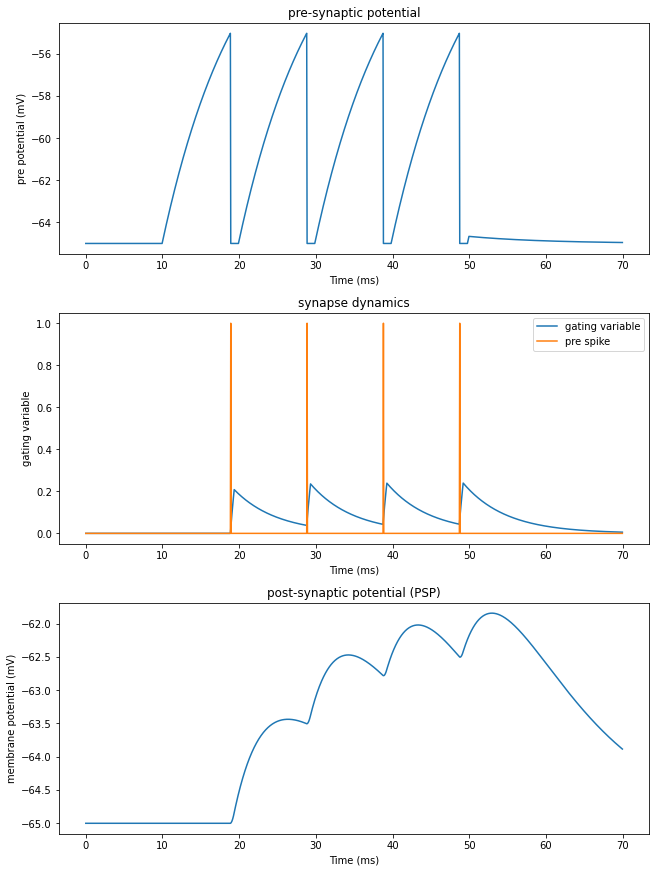

In [10]:
(step_I, duration) = bp.inputs.constant_current([(0, 10), (16.9, 40), (0, 20)])

pre, post = get_neurons()
syn = AMPA2_numba(pre=pre, post=post, conn=bp.connect.All2All(), monitors=['s'])
net = bp.Network(pre, syn, post)
net.run(duration, inputs=(pre, "input", step_I))

get_plots(net.ts, syn.mon.s, pre.mon.V, post.mon.V, pre.mon.spike)

# NMDA synapse model

## Model overview

NMDA receptor is other receptor of neurotransmitter `Glutamate`.

NMDA-receptor controlled channels exhibit a rich repertoire of dynamic behavior because their state is not only controlled by the presence or absence of glutamate, but also by the membrane potential. 

At resting potential, the NMDA channel is blocked by a common extracellular ion, ${\rm Mg}^{2+}$, even if glutamate is present. If the membrane is depolarized beyond −50 mV, the ${\rm Mg}^{2+}$-block is removed, the channel opens when glutamate binds to the receptor and, thereafter, stays open for 10 – 100 milliseconds.

A simple model of the voltage dependence of NMDA-receptor controlled channels is

$$ g(t) = \bar{g}_{syn} \cdot g_{\infty}  s $$

where

$$ g_{\infty}(V,[{Mg}^{2+}]_{o}) =(1+{e}^{-\alpha V} \cdot \frac{[{Mg}^{2+}]_{o} } {\beta})^{-1}  $$

Dynamics of $s$ is given by:

$$ \frac{d s_{j}(t)}{dt} =-\frac{s_{j}(t)}{\tau_{decay}}+a x_{j}(t)(1-s_{j}(t))  $$

$$ \frac{d x_{j}(t)}{dt} =-\frac{x_{j}(t)}{\tau_{rise}}+
\sum_{k} \delta(t-t_{j}^{k})  $$

where the decay time of NMDA currents is taken to be $\tau_{decay}=100 ms$,
$a= 0.5 ms^{-1}$, and$\tau_{rise} =2 ms$ (Hestrin et al., 1990; Spruston et al., 1995).

Again, the synaptic current is:

$$ I_{syn}= g(t) \cdot (V-E_{syn})$$

In [11]:
class NMDA(bp.TwoEndConn):    
    target_backend = 'general'

    @staticmethod
    def derivative(s, x, t, tau_rise, tau_decay, a):
        dxdt = -x / tau_rise
        dsdt = -s / tau_decay + a * x * (1 - s)
        return dsdt, dxdt
    
    def __init__(self, pre, post, conn, delay=0., g_max=0.15, E=0., cc_Mg=1.2,
                    alpha=0.062, beta=3.57, tau=100, a=0.5, tau_rise = 2., **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.cc_Mg = cc_Mg
        self.tau = tau
        self.tau_rise = tau_rise
        self.a = a
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.backend.shape(self.conn_mat)

        # variables
        self.s = bp.backend.zeros(self.size)
        self.x = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

        self.integral = bp.odeint(f=self.derivative, method='rk4')
        
        super(NMDA, self).__init__(pre=pre, post=post, **kwargs)


    def update(self, _t):
        self.x += bp.backend.unsqueeze(self.pre.spike, 1) * self.conn_mat        
        self.s, self.x = self.integral(self.s, self.x, _t, self.tau_rise, self.tau, self.a)
        
        self.g.push(self.g_max * self.s)
        g_inf = 1 + self.cc_Mg / self.beta * bp.backend.exp(-self.alpha * self.post.V)
        g_inf = 1 / g_inf
        self.post.input -= bp.backend.sum(self.g.pull(), axis=0) * (self.post.V - self.E) * g_inf

### Simulation

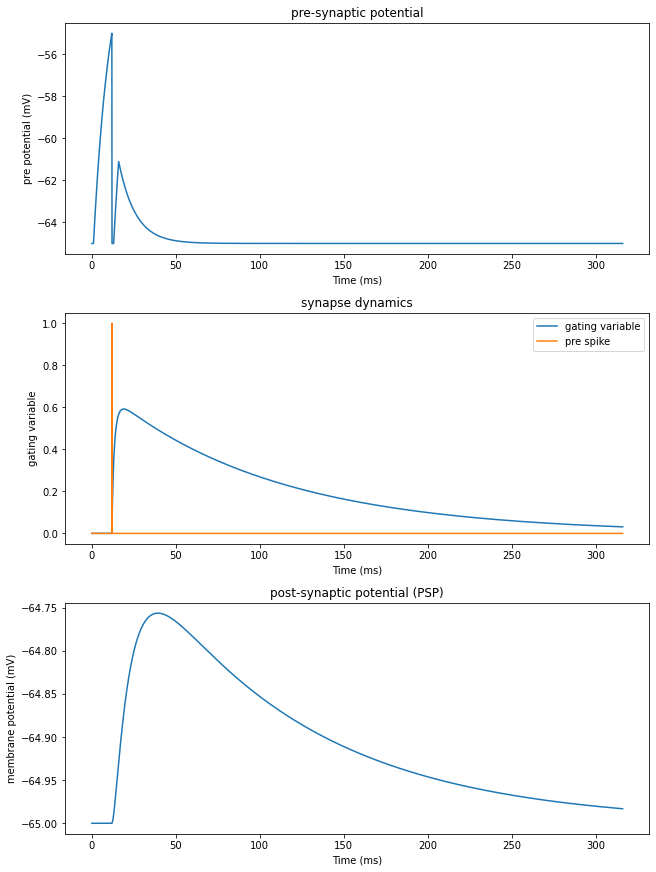

In [12]:
bp.backend.set(backend='numpy')

(step_I, duration) = bp.inputs.constant_current([(0, 1), (15, 15), (0, 300)])

pre, post = get_neurons()
syn = NMDA(pre=pre, post=post, conn=bp.connect.All2All(), monitors=['s'])
net = bp.Network(pre, syn, post)
net.run(duration, inputs=(pre, "input", step_I))

get_plots(net.ts, syn.mon.s, pre.mon.V, post.mon.V, pre.mon.spike)

### NMDA numba backend implementation

In [13]:
class NMDA_numba(bp.TwoEndConn):    
    target_backend = ['numpy', 'numba', 'numba-parallel', 'numba-cuda']

    @staticmethod
    def derivative(s, x, t, tau_rise, tau_decay, a):
        dxdt = -x / tau_rise
        dsdt = -s / tau_decay + a * x * (1 - s)
        return dsdt, dxdt
    
    def __init__(self, pre, post, conn, delay=0., g_max=0.15, E=0., cc_Mg=1.2,
                    alpha=0.062, beta=3.57, tau=100, a=0.5, tau_rise = 2., **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.cc_Mg = cc_Mg
        self.tau = tau
        self.tau_rise = tau_rise
        self.a = a
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
        self.size = len(self.pre_ids)

        # variables
        self.s = bp.backend.zeros(self.size)
        self.x = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

        self.integral = bp.odeint(f=self.derivative, method='rk4')
        
        super(NMDA_numba, self).__init__(pre=pre, post=post, **kwargs)

    
    def update(self, _t):
        for i in prange(self.size):
            pre_id = self.pre_ids[i]

            self.x[i] += self.pre.spike[pre_id]
            self.s[i], self.x[i] = self.integral(self.s[i], self.x[i], _t, self.tau_rise, self.tau, self.a)

            # output
            self.g.push(i, self.g_max * self.s[i])

            post_id = self.post_ids[i]

            g_inf = 1 + self.cc_Mg / self.beta * bp.backend.exp(-self.alpha * self.post.V[post_id])

            self.post.input[post_id] -= self.g.pull(i) * (self.post.V[post_id] - self.E) / g_inf

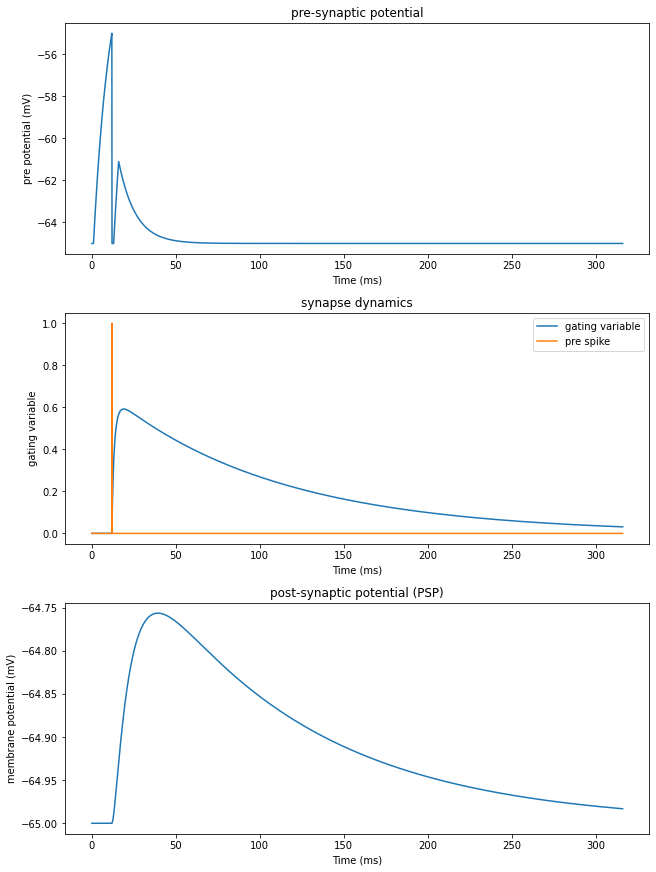

In [14]:
bp.backend.set(backend='numba')

(step_I, duration) = bp.inputs.constant_current([(0, 1), (15, 15), (0, 300)])

pre, post = get_neurons()
syn = NMDA_numba(pre=pre, post=post, conn=bp.connect.All2All(), monitors=['s'])
net = bp.Network(pre, syn, post)
net.run(duration, inputs=(pre, "input", step_I))

get_plots(net.ts, syn.mon.s, pre.mon.V, post.mon.V, pre.mon.spike)

## Excitatory synapses: AMPA and NMDA

AMPA and NMDA are two receptors of Glutamate, let's see the difference of the two receptors after the coming of Glutamate.

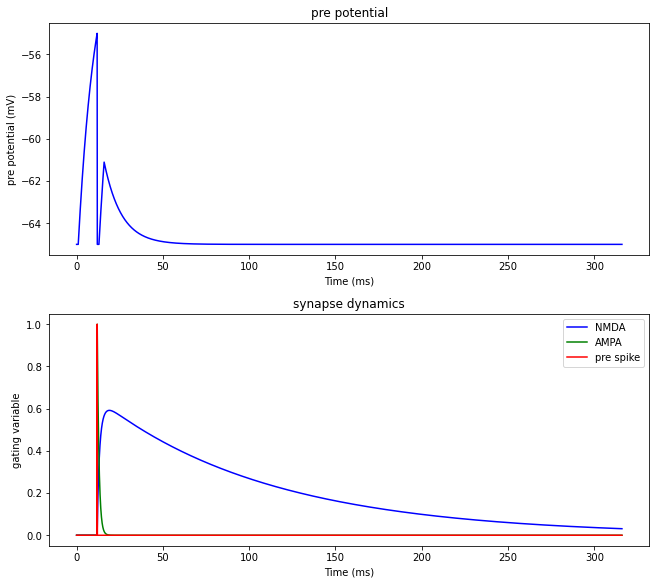

In [15]:
(I_ext, duration) = bp.inputs.constant_current([(0, 1), (15, 15), (0, 300)])

# AMPA
a_pre, a_post = get_neurons()
ampa = AMPA1(pre=a_pre, post=a_post, conn=bp.connect.All2All(), monitors=['s'], tau=1.)
net_ampa = bp.Network(a_pre, ampa, a_post)

# NMDA
n_pre, n_post = get_neurons()
nmda = NMDA(pre=n_pre, post=n_post, conn=bp.connect.All2All(), monitors=['s'])
net_nmda = bp.Network(n_pre, nmda, n_post)

# run simulation
net_nmda.run(duration, inputs=(n_pre, "input", I_ext))
net_ampa.run(duration, inputs=(a_pre, "input", I_ext))

# visualization
fig, gs = bp.visualize.get_figure(2, 1, 4, 9)

ts = net_nmda.ts

# pre potential
fig.add_subplot(gs[0, 0])
plt.plot(ts, n_pre.mon.V[:, 0], 'b')
plt.ylabel('pre potential (mV)')
plt.xlabel('Time (ms)')
plt.title('pre potential')

# synapse
fig.add_subplot(gs[1, 0])
plt.plot(ts, nmda.mon.s[:, 0], 'b', label='NMDA')
plt.plot(ts, ampa.mon.s[:, 0], 'g', label='AMPA')
plt.plot(ts, n_pre.mon.spike[:, 0], 'r', label='pre spike')
plt.ylabel('gating variable')
plt.xlabel('Time (ms)')
plt.title('synapse dynamics')
plt.legend()
plt.show()

Our simulation results correspond to the biological data that AMPA receptors decay rapidly and NMDA receptors often decay much slower. 

**References:**

[1] Brunel N, Wang X J. Effects of neuromodulation in a 
               cortical network model of object working memory dominated 
               by recurrent inhibition[J]. 
               Journal of computational neuroscience, 2001, 11(1): 63-85.
 
[2] Gerstner, Wulfram, et al. Neuronal dynamics: From single 
               neurons to networks and models of cognition. Cambridge 
               University Press, 2014.